2022-06-10 11:58:36.586 | INFO     | gdsfactory.config:<module>:52 - Load '/home/lucas/anaconda3/lib/python3.9/site-packages/gdsfactory' 5.8.3


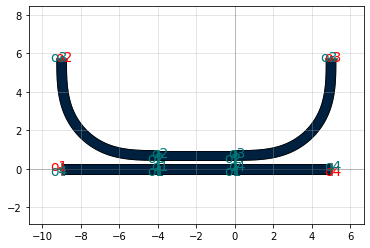

coupler_ring: uid 0, ports ['o2', 'o1', 'o3', 'o4'], aliases [], 0 polygons, 3 references

In [1]:
from typing import Optional

import gdsfactory as gf
from gdsfactory.component import Component
from gdsfactory.components.bend_euler import bend_euler
from gdsfactory.components.coupler90 import coupler90 as coupler90function
from gdsfactory.components.coupler_straight import (
    coupler_straight as coupler_straight_function,
)
from gdsfactory.components.straight import straight as straight_function
from gdsfactory.cross_section import strip
from gdsfactory.snap import assert_on_2nm_grid
from gdsfactory.types import ComponentSpec, CrossSectionSpec


@gf.cell
def coupler_ring(
    gap: float = 0.2,
    radius: float = 5.0,
    length_x: float = 4.0,
    coupler90: ComponentSpec = coupler90function,
    bend: Optional[ComponentSpec] = None,
    straight: ComponentSpec = straight_function,
    coupler_straight: ComponentSpec = coupler_straight_function,
    cross_section: CrossSectionSpec = strip,
    bend_cross_section: Optional[CrossSectionSpec] = None,
    **kwargs
) -> Component:
    r"""Coupler for ring.

    Args:
        gap: spacing between parallel coupled straight waveguides.
        radius: of the bends.
        length_x: length of the parallel coupled straight waveguides.
        coupler90: straight coupled to a 90deg bend.
        bend: bend spec.
        coupler_straight: two parallel coupled straight waveguides.
        cross_section: cross_section spec.
        bend_cross_section: optional bend cross_section spec.
        kwargs: cross_section settings for bend and coupler.

    .. code::

           2             3
           |             |
            \           /
             \         /
           ---=========---
         1    length_x    4


    """
    bend = bend or bend_euler

    c = Component()
    assert_on_2nm_grid(gap)

    # define subcells
    coupler90_component = gf.get_component(
        coupler90,
        gap=gap,
        radius=radius,
        bend=bend,
        cross_section=cross_section,
        bend_cross_section=bend_cross_section,
        **kwargs
    )
    coupler_straight_component = gf.get_component(
        coupler_straight,
        gap=gap,
        length=length_x,
        cross_section=cross_section,
        straight=straight,
        **kwargs
    )

    # add references to subcells
    cbl = c << coupler90_component
    cbr = c << coupler90_component
    cs = c << coupler_straight_component

    # connect references
    y = coupler90_component.y
    cs.connect(port="o4", destination=cbr.ports["o1"])
    cbl.reflect(p1=(0, y), p2=(1, y))
    cbl.connect(port="o2", destination=cs.ports["o2"])

    c.add_port("o1", port=cbl.ports["o3"])
    c.add_port("o2", port=cbl.ports["o4"])
    c.add_port("o3", port=cbr.ports["o3"])
    c.add_port("o4", port=cbr.ports["o4"])
    c.auto_rename_ports()
    return c



coupler = coupler_ring()
coupler.show()
coupler


In [8]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle
#os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\')
#lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py') 
sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/media/lucas/datam01/LucasLobo/Design_MMI_LucasLobo/Lumerical')) #Current directory

In [3]:
nf = 3.476
ns = 1.444
espessuraTotal = 10e-6
lmbd = 1550e-9
c0 = 299792458
k0 = 2*np.pi/lmbd
numerodemodos = 1
sigma = 0
We = espessuraTotal + (lmbd/np.pi)*((ns/nf)**(2*sigma))*(nf**2 - ns**2)**(-1/2)

a = espessuraTotal/2 - 4.25e-6
print(a)

7.500000000000004e-07


In [9]:
mode = lumapi.MODE(filename= 'MMI2XN.lms')

In [5]:
mode.runsweep('s-parameter sweep')

In [15]:
x = [6e-06,1e-6,6e-6]
print(x)

[6e-06, 1e-06, 6e-06]


In [33]:
campo2 = abs(campo)**2
print(campo2[0,:])
campos = campo2[0,:]
campos = np.stack((campos,campo2[0,:]))

[1.29019312e-05 2.33694399e-01 2.45216895e-01 2.33770430e-01
 2.37074011e-01]


In [39]:
for i in range(len(k)):
    print(i)

0
1
2
3
4


In [167]:
#sweep temperatura
k = [250,300,350]
for i in range(len(k)):
    print(i+1)
    mode.switchtolayout()
    mode.setnamed('EME','simulation temperature',k[i])
    mode.run()
    mode.setemeanalysis('group spans',np.transpose([6e-06,181*1e-6,6e-6]))
    mode.emepropagate()

    mode.setemeanalysis("wavelength sweep",1)
    mode.setemeanalysis('start wavelength',1.540e-6)
    mode.setemeanalysis('stop wavelength',1.56e-6)
    mode.setemeanalysis('number of wavelength points',10)
    mode.emesweep("wavelength sweep")
    comprimentos = mode.getemesweep("S_wavelength_sweep")
    x = comprimentos['wavelength']
    s12n = abs(comprimentos['s13'])**2
    s13n = abs(comprimentos['s14'])**2
    s14n = abs(comprimentos['s15'])**2
    s15n = abs(comprimentos['s16'])**2
    if(i == 0):
        s12 = s12n
        s13 = s13n
        s14 = s14n
        s15 = s15n

        arquivo=open('temps12','wb')
        pickle.dump(s12, arquivo)
        arquivo.close()
        arquivo=open('temps13','wb')
        pickle.dump(s13, arquivo)
        arquivo.close()
        arquivo=open('temps14','wb')
        pickle.dump(s14, arquivo)
        arquivo.close()
        arquivo=open('temps15','wb')
        pickle.dump(s15, arquivo)
        arquivo.close()
    else:
        s12 = np.vstack((s12,s12n))
        s13 = np.vstack((s13,s13n))
        s14 = np.vstack((s14,s14n))
        s15 = np.vstack((s15,s15n))

        arquivo=open('temps12','wb')
        pickle.dump(s12, arquivo)
        arquivo.close()
        arquivo=open('temps13','wb')
        pickle.dump(s13, arquivo)
        arquivo.close()
        arquivo=open('temps14','wb')
        pickle.dump(s14, arquivo)
        arquivo.close()
        arquivo=open('temps15','wb')
        pickle.dump(s15, arquivo)
        arquivo.close()
mode.switchtolayout()
mode.setnamed('EME','simulation temperature',300)








1
2
3


In [ ]:
arquivo=open('temps12','rb')
pickle.dump(s12, arquivo)
arquivo.close()
arquivo=open('temps13','rb')
pickle.dump(s13, arquivo)
arquivo.close()
arquivo=open('temps14','rb')
pickle.dump(s14, arquivo)
arquivo.close()
arquivo=open('temps15','rb')
pickle.dump(s15, arquivo)
arquivo.close()

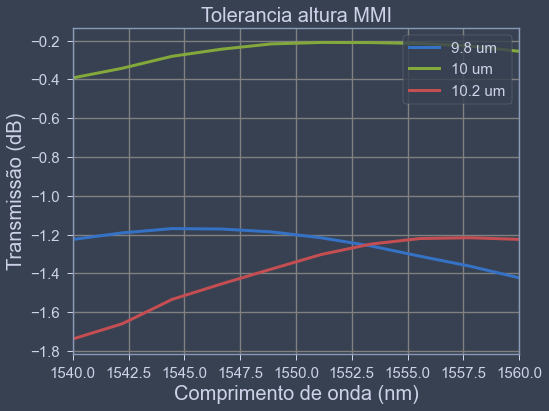

In [201]:

#plt.plot(x*1e9,10*np.log10(s15[0]),label='0.2156 um',linewidth=3)
#plt.plot(x*1e9,10*np.log10(s15[1]),label='0.22 um',linewidth=3)
#plt.plot(x*1e9,10*np.log10(s15[2]),label='0.2244 um',linewidth=3)

plt.plot(x*1e9,10*np.log10(s12[0]+s13[0]+s14[0]+s15[0]),label='9.8 um',linewidth=3)
plt.plot(x*1e9,10*np.log10(s12[1]+s13[1]+s14[1]+s15[1]),label='10 um',linewidth=3)
plt.plot(x*1e9,10*np.log10(s12[2]+s13[2]+s14[2]+s15[2]),label='10.2 um',linewidth=3)

plt.legend(fontsize=15,loc='upper right')
plt.title('Tolerancia altura MMI',fontsize=20)
#plt.ylim(-7,-5.5)
plt.xlim(1540,1560)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Comprimento de onda (nm)',fontsize=20)
plt.ylabel('Transmissão (dB)',fontsize=20)
plt.grid(color='grey')
plt.savefig('espessura')

In [172]:
#sweep espessura
k = [9.8e-6,10e-6,10.2e-6]
for i in range(len(k)):
    print(i+1)
    mode.switchtolayout()
    mode.setnamed('MMI','y span',k[i])
    mode.run()
    mode.setemeanalysis('group spans',np.transpose([6e-06,181*1e-6,6e-6]))
    mode.emepropagate()

    mode.setemeanalysis("wavelength sweep",1)
    mode.setemeanalysis('start wavelength',1.540e-6)
    mode.setemeanalysis('stop wavelength',1.56e-6)
    mode.setemeanalysis('number of wavelength points',10)
    mode.emesweep("wavelength sweep")
    comprimentos = mode.getemesweep("S_wavelength_sweep")
    x = comprimentos['wavelength']
    s12n = abs(comprimentos['s13'])**2
    s13n = abs(comprimentos['s14'])**2
    s14n = abs(comprimentos['s15'])**2
    s15n = abs(comprimentos['s16'])**2
    if(i == 0):
        s12 = s12n
        s13 = s13n
        s14 = s14n
        s15 = s15n

        arquivo=open('largs12','wb')
        pickle.dump(s12, arquivo)
        arquivo.close()
        arquivo=open('largs13','wb')
        pickle.dump(s13, arquivo)
        arquivo.close()
        arquivo=open('largs14','wb')
        pickle.dump(s14, arquivo)
        arquivo.close()
        arquivo=open('largs15','wb')
        pickle.dump(s15, arquivo)
        arquivo.close()
    else:
        s12 = np.vstack((s12,s12n))
        s13 = np.vstack((s13,s13n))
        s14 = np.vstack((s14,s14n))
        s15 = np.vstack((s15,s15n))

        arquivo=open('largs12','wb')
        pickle.dump(s12, arquivo)
        arquivo.close()
        arquivo=open('largs13','wb')
        pickle.dump(s13, arquivo)
        arquivo.close()
        arquivo=open('largs14','wb')
        pickle.dump(s14, arquivo)
        arquivo.close()
        arquivo=open('largs15','wb')
        pickle.dump(s15, arquivo)
        arquivo.close()
#mode.switchtolayout()
#mode.setnamed('MMI','y span',10e-6)

1
2
3


In [196]:
#sweep altura
k = [0.2156e-6,0.22e-6,0.2244e-6]
for i in range(len(k)):
    print(i+1)
    mode.switchtolayout()
    mode.setnamed('MMI','z span',k[i])

    mode.setnamed('I1','z span',k[i])
    mode.setnamed('TI1','thickness',k[i])

    mode.setnamed('I2','z span',k[i])
    mode.setnamed('TI2','thickness',k[i])

    mode.setnamed('O1','z span',k[i])
    mode.setnamed('TO1','thickness',k[i])

    mode.setnamed('O2','z span',k[i])
    mode.setnamed('TO2','thickness',k[i])

    mode.setnamed('O3','z span',k[i])
    mode.setnamed('TO3','thickness',k[i])

    mode.setnamed('O4','z span',k[i])
    mode.setnamed('TO4','thickness',k[i])
    mode.run()
    mode.setemeanalysis('group spans',np.transpose([6e-06,181*1e-6,6e-6]))
    mode.emepropagate()

    mode.setemeanalysis("wavelength sweep",1)
    mode.setemeanalysis('start wavelength',1.540e-6)
    mode.setemeanalysis('stop wavelength',1.56e-6)
    mode.setemeanalysis('number of wavelength points',10)
    mode.emesweep("wavelength sweep")
    comprimentos = mode.getemesweep("S_wavelength_sweep")
    x = comprimentos['wavelength']
    s12n = abs(comprimentos['s13'])**2
    s13n = abs(comprimentos['s14'])**2
    s14n = abs(comprimentos['s15'])**2
    s15n = abs(comprimentos['s16'])**2
    if(i == 0):
        s12 = s12n
        s13 = s13n
        s14 = s14n
        s15 = s15n

        arquivo=open('alts12','wb')
        pickle.dump(s12, arquivo)
        arquivo.close()
        arquivo=open('alts13','wb')
        pickle.dump(s13, arquivo)
        arquivo.close()
        arquivo=open('alts14','wb')
        pickle.dump(s14, arquivo)
        arquivo.close()
        arquivo=open('alts15','wb')
        pickle.dump(s15, arquivo)
        arquivo.close()
    else:
        s12 = np.vstack((s12,s12n))
        s13 = np.vstack((s13,s13n))
        s14 = np.vstack((s14,s14n))
        s15 = np.vstack((s15,s15n))

        arquivo=open('alts12','wb')
        pickle.dump(s12, arquivo)
        arquivo.close()
        arquivo=open('alts13','wb')
        pickle.dump(s13, arquivo)
        arquivo.close()
        arquivo=open('alts14','wb')
        pickle.dump(s14, arquivo)
        arquivo.close()
        arquivo=open('alts15','wb')
        pickle.dump(s15, arquivo)
        arquivo.close()

mode.switchtolayout()
mode.setnamed('MMI','z span',0.22e-6)

mode.setnamed('I1','z span',0.22e-6)
mode.setnamed('TI1','thickness',0.22e-6)

mode.setnamed('I2','z span',0.22e-6)
mode.setnamed('TI2','thickness',0.22e-6)

mode.setnamed('O1','z span',0.22e-6)
mode.setnamed('TO1','thickness',0.22e-6)

mode.setnamed('O2','z span',0.22e-6)
mode.setnamed('TO2','thickness',0.22e-6)

mode.setnamed('O3','z span',0.22e-6)
mode.setnamed('TO3','thickness',0.22e-6)

mode.setnamed('O4','z span',0.22e-6)
mode.setnamed('TO4','thickness',0.22e-6)

#mode.runsweep('s-parameter sweep')

1
2
3


In [186]:
mode.runsweep('s-parameter sweep')

KeyboardInterrupt: 

In [19]:
posicao = np.linspace(3.83077e-6,4.23077e-6,4)

#posicao = np.linspace(-4.23077e-6,-3.8e-6,4)
#posicao = np.linspace(-0.769231e-6,-1e-6,6)
for i in range(len(posicao)):
    print(i+1)
    mode.switchtolayout()
    mode.setnamed('TI1','y',posicao[i])     
    mode.setnamed('I1','y',posicao[i])
    mode.setnamed('EME::Ports::port_1','y',posicao[i])
    mode.run()
    mode.setemeanalysis('group spans',np.transpose([6e-06,181*1e-6,6e-6]))
    mode.emepropagate()
    
    campon = mode.getresult('EME','user s matrix')
    if(i == 0):
        campo = campon[0,:]

        arquivo=open('sposicaoin','wb')
        pickle.dump(campo, arquivo)
        arquivo.close()

    else:
        campo = np.vstack((campo,campon[0,:]))
        
        arquivo=open('sposicaoin','wb')
        pickle.dump(campo, arquivo)
        arquivo.close()





1
2
3
4


In [91]:
abs(np.linspace(-4.23077e-6,-3.8e-6,4))

array([4.23077e-06, 4.08718e-06, 3.94359e-06, 3.80000e-06])

In [128]:
arquivo = open('sposicaodentro','rb')
campo = pickle.load(arquivo)
arquivo.close()
campo = campo**2

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  possible_flags = {'C': 'C', 'C_CONTIGUOUS': 'C', 'CONTIGUOUS': 'C',


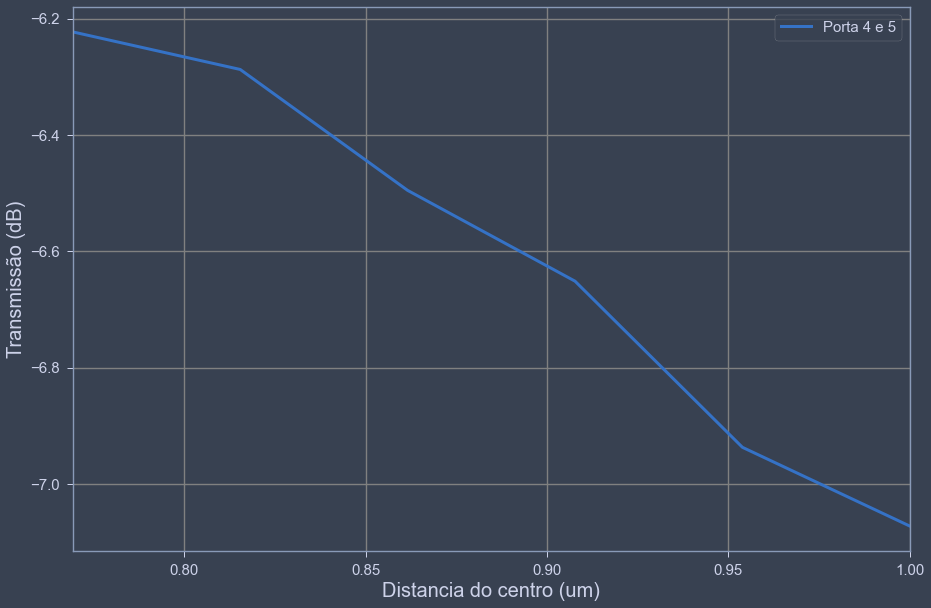

In [131]:
#posicao = [4.23077, 4.08718, 3.94359, 3.80000]

#posicao = np.linspace(-4.23077e-6,-3.8e-6,4)
posicao = abs(np.linspace(-0.769231,-1,6))
#teste = abs(posicao)
#arquivo = open('sposicaofora','rb')
#campo = pickle.load(arquivo)
#arquivo.close()
# arquivo = open('temps12', 'rb')
# treco = pickle.load(arquivo)
# arquivo.close()
#plt.plot(x*1e9,10*np.log10(abs(s12[0,:])**2),label='s1',linewidth=3)
plt.plot(posicao,10*np.log10(campo[:,3]),label='Porta 4 e 5',linewidth=3)

#plt.plot(x*1e9,10*np.log10(s12[2]),label='s2',linewidth=3)
#plt.plot(x*1e9,10*np.log10(s12[1,:]),label='s2',linewidth=3)
#plt.plot(x*1e9,10*np.log10(abs(s14)**2),label='porta4',linewidth=3)
#plt.plot(x*1e9,10*np.log10(abs(s15)**2),label='porta5',linewidth=3)
#plt.plot(x*1e9,10*np.log10(abs(s16)**2),label='porta6',linewidth=3)
plt.legend(fontsize=15)
#plt.ylim(-7,-5.5)
plt.xlim(0.769231,1)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Distancia do centro (um)',fontsize=20)
plt.ylabel('Transmissão (dB)',fontsize=20)
plt.grid(color='grey')
plt.savefig('Posicaoentrada')

In [152]:
# mode.setnamed('TI1','y',(espessuraTotal/2 - a)) 
# mode.setnamed('I1','y',(espessuraTotal/2 - a))
# mode.setnamed('EME::Ports::port_1','y',(espessuraTotal/2 - a))


# mode.setnamed('TO1','y',(espessuraTotal/2 - a))
# mode.setnamed('O1','y',(espessuraTotal/2 - a))
# mode.setnamed('EME::Ports::port_2','y',(espessuraTotal/2 - a))

# mode.setnamed('TO2','y',(espessuraTotal/2 - 2*espessuraTotal/4 + a))
# mode.setnamed('O2','y',(espessuraTotal/2 - 2*espessuraTotal/4 + a))
# mode.setnamed('EME::Ports::port_3','y',(espessuraTotal/2 - 2*espessuraTotal/4 + a))

# mode.setnamed('TO3','y',(espessuraTotal/2 - 2*espessuraTotal/4 - a))
# mode.setnamed('O3','y',(espessuraTotal/2 - 2*espessuraTotal/4 - a))
# mode.setnamed('EME::Ports::port_4','y',(espessuraTotal/2 - 2*espessuraTotal/4 - a))

# mode.setnamed('TO4','y',(espessuraTotal/2 - 4*espessuraTotal/4 + a))     
# mode.setnamed('O4','y',(espessuraTotal/2 - 4*espessuraTotal/4 + a))
# mode.setnamed('EME::Ports::port_5','y',(espessuraTotal/2 - 4*espessuraTotal/4 + a))

mode.setnamed('TI1','y',(espessuraTotal/2 - 0.76e-6)) 
mode.setnamed('I1','y',(espessuraTotal/2 - 0.76e-6))
mode.setnamed('EME::Ports::port_1','y',(espessuraTotal/2 - 0.76e-6))


mode.setnamed('TO1','y',(espessuraTotal/2 - 0.76e-6))
mode.setnamed('O1','y',(espessuraTotal/2 - 0.76e-6))
mode.setnamed('EME::Ports::port_2','y',(espessuraTotal/2 - 0.76e-6))

mode.setnamed('TO2','y',(espessuraTotal/2 - 2*espessuraTotal/4 + 0.76e-6))
mode.setnamed('O2','y',(espessuraTotal/2 - 2*espessuraTotal/4 + 0.76e-6))
mode.setnamed('EME::Ports::port_3','y',(espessuraTotal/2 - 2*espessuraTotal/4 + 0.76e-6))

mode.setnamed('TO3','y',(espessuraTotal/2 - 2*espessuraTotal/4 - 0.76e-6))
mode.setnamed('O3','y',(espessuraTotal/2 - 2*espessuraTotal/4 - 0.76e-6))
mode.setnamed('EME::Ports::port_4','y',(espessuraTotal/2 - 2*espessuraTotal/4 - 0.76e-6))

mode.setnamed('TO4','y',(espessuraTotal/2 - 4*espessuraTotal/4 + 0.76e-6))     
mode.setnamed('O4','y',(espessuraTotal/2 - 4*espessuraTotal/4 + 0.76e-6))
mode.setnamed('EME::Ports::port_5','y',(espessuraTotal/2 - 4*espessuraTotal/4 + 0.76e-6))

In [8]:
mode.emepropagate()

NameError: name 'mode' is not defined

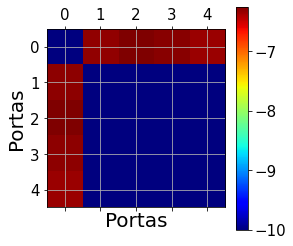

In [20]:
campo = mode.getresult('EME','user s matrix')
campo = abs(campo)**2
#campo = 10*np.log10(campo)
#[print(*line) for line in campo]
plt.matshow(10*np.log10(campo),cmap = 'jet',vmin=-10)
plt.xlabel('Portas',fontsize=20)
plt.ylabel('Portas',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.grid()
plt.savefig('MatrizS')

In [20]:
#np.savetxt('MatrizS.csv', campo, delimiter=',') 

In [21]:
mode.setemeanalysis("mode convergence sweep", 1)
mode.emesweep("mode convergence sweep")
modos = mode.getemesweep("S_mode_convergence_sweep")

KeyboardInterrupt: 

dict_keys(['modes', 's11', 's21', 's31', 's41', 's51', 's61', 's12', 's22', 's32', 's42', 's52', 's62', 's13', 's23', 's33', 's43', 's53', 's63', 's14', 's24', 's34', 's44', 's54', 's64', 's15', 's25', 's35', 's45', 's55', 's65', 's16', 's26', 's36', 's46', 's56', 's66', 'Lumerical_dataset'])


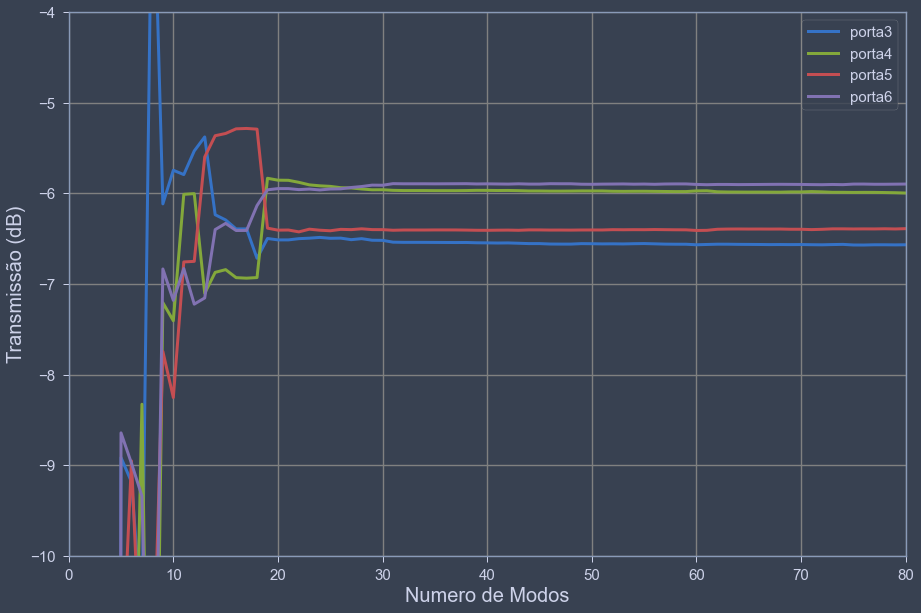

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
print(modos.keys())
x = modos['modes']
s13 = modos['s13']
s14 = modos['s14']
s15 = modos['s15']
s16 = modos['s16']

plt.plot(x,10*np.log10(abs(s13)**2),label='porta3',linewidth=3)
plt.plot(x,10*np.log10(abs(s14)**2),label='porta4',linewidth=3)
plt.plot(x,10*np.log10(abs(s15)**2),label='porta5',linewidth=3)
plt.plot(x,10*np.log10(abs(s16)**2),label='porta6',linewidth=3)
plt.legend(fontsize=15)
plt.ylim(-10,-5)
plt.yticks(np.arange(-10,-3,step=1),fontsize=15)
plt.xticks(np.arange(0,100,step=10),fontsize=15)
plt.xlim(0,80)
plt.xlabel('Numero de Modos',fontsize=20)
plt.ylabel('Transmissão (dB)',fontsize=20)
plt.grid(color='grey')
plt.savefig('ConvergenciaModos')

In [4]:
mode.setemeanalysis("wavelength sweep",1)
mode.emesweep("wavelength sweep")
comprimentos = mode.getemesweep("S_wavelength_sweep")

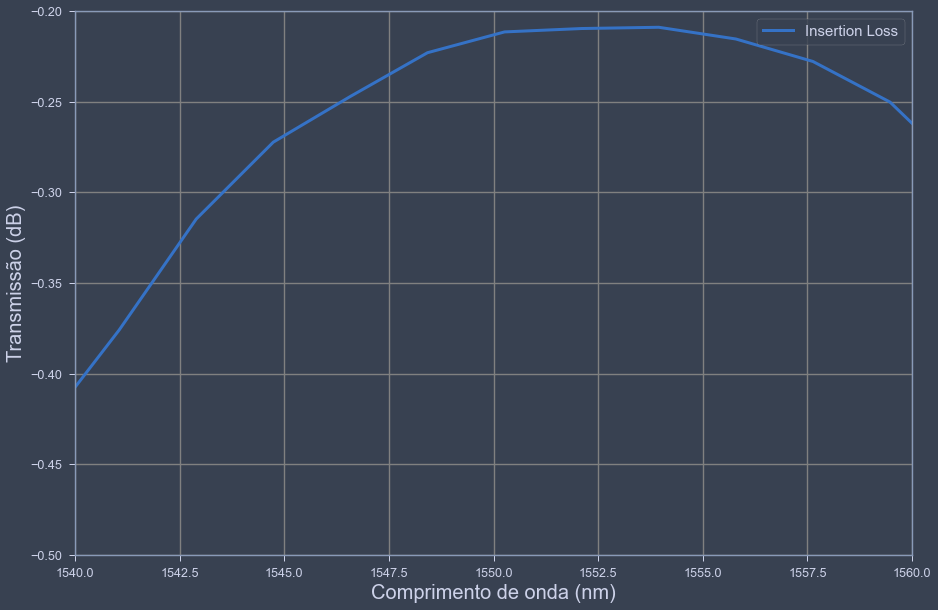

In [10]:
plt.rcParams["figure.figsize"] = (15,10)
s13 = comprimentos['s13']
s14 = comprimentos['s14']
s15 = comprimentos['s15']
s16 = comprimentos['s16']
x = comprimentos['wavelength']

#plt.plot(x*1e9,10*np.log10(abs(s13)**2),label='porta3',linewidth=3)
#plt.plot(x*1e9,10*np.log10(abs(s14)**2),label='porta4',linewidth=3)
#plt.plot(x*1e9,10*np.log10(abs(s15)**2),label='porta5',linewidth=3)
#plt.plot(x*1e9,10*np.log10(abs(s16)**2),label='porta6',linewidth=3)
plt.plot(x*1e9,10*np.log10(abs(s16)**2+abs(s15)**2+abs(s14)**2+abs(s13)**2),label='Insertion Loss',linewidth=3)
plt.legend(fontsize=15)
plt.ylim(-0.5,-0.2)
plt.xlim(1540,1560)
#plt.yticks(np.arange(-7,-5.5,step=0.25),fontsize=15)
#plt.xticks(np.arange(1530,1565,step=5),fontsize=15)
plt.xlabel('Comprimento de onda (nm)',fontsize=20)
plt.ylabel('Transmissão (dB)',fontsize=20)
plt.grid(color='grey')
plt.savefig('sweepfrequencia')

In [60]:
mode.setemeanalysis("propagation sweep",1)
mode.emesweep("propagation sweep")

dict_keys(['group_span_2', 's11', 's21', 's31', 's41', 's51', 's61', 's12', 's22', 's32', 's42', 's52', 's62', 's13', 's23', 's33', 's43', 's53', 's63', 's14', 's24', 's34', 's44', 's54', 's64', 's15', 's25', 's35', 's45', 's55', 's65', 's16', 's26', 's36', 's46', 's56', 's66', 'Lumerical_dataset'])


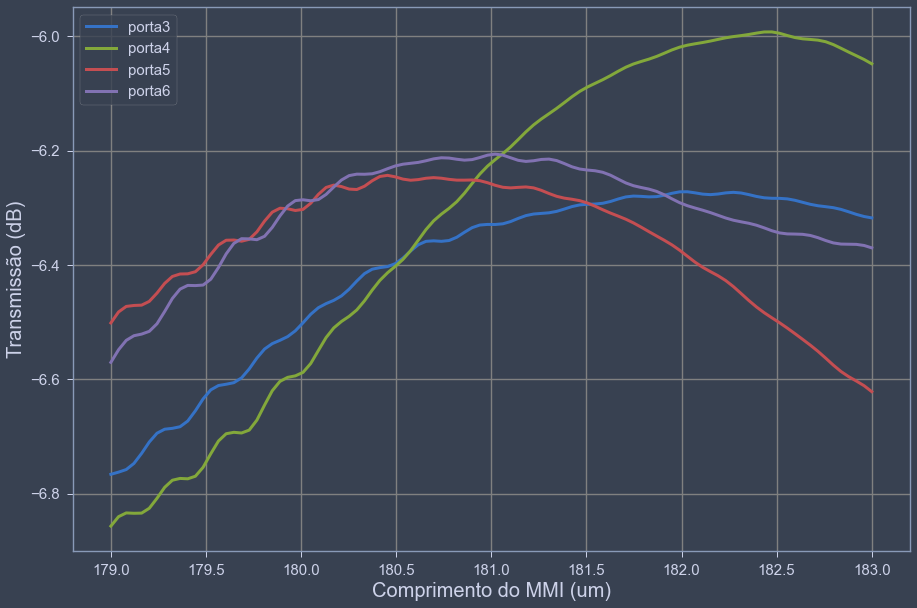

In [154]:

largura = mode.getemesweep("S")

plt.rcParams["figure.figsize"] = (15,10)
print(largura.keys())
x = largura['group_span_2']
s13 = largura['s13']
s14 = largura['s14']
s15 = largura['s15']
s16 = largura['s16']

plt.plot(x*1e6,10*np.log10(abs(s13)**2),label='porta3',linewidth=3)
plt.plot(x*1e6,10*np.log10(abs(s14)**2),label='porta4',linewidth=3)
plt.plot(x*1e6,10*np.log10(abs(s15)**2),label='porta5',linewidth=3)
plt.plot(x*1e6,10*np.log10(abs(s16)**2),label='porta6',linewidth=3)
plt.legend(fontsize=15)
#plt.ylim(-7,-5.5)
#plt.xlim(56,62)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Comprimento do MMI (um)',fontsize=20)
plt.ylabel('Transmissão (dB)',fontsize=20)
plt.grid(color='grey')
plt.savefig('sweepcomprimento')

dict_keys(['lambda', 'f', 'x', 'y', 'z', 'E', 'H', 'Lumerical_dataset'])


C:\Users\lucas\AppData\Local\Temp/ipykernel_10372/3354644031.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
C:\Users\lucas\AppData\Local\Temp/ipykernel_10372/3354644031.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


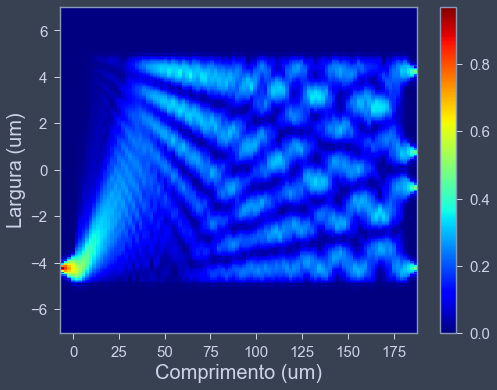

In [157]:
campo = mode.getresult('monitor','field profile')
print(campo.keys())
x = campo['x']
y = campo['y']
E = campo['E']

E = np.sqrt(E[:,:,0,:,0]**2 + E[:,:,0,:,1]**2 + E[:,:,0,:,2]**2)
E = np.transpose(abs(E[:,:,0]))
np.shape(x[:,0])

plt.rcParams["figure.figsize"] = (8,6)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,E,cmap = 'jet')
plt.xlabel('Comprimento (um)',fontsize=20)
plt.ylabel('Largura (um)',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.savefig('E linear')


C:\Users\lucas\AppData\Local\Temp/ipykernel_10372/539426206.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet',vmin=-30)
C:\Users\lucas\AppData\Local\Temp/ipykernel_10372/539426206.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(label='dB')


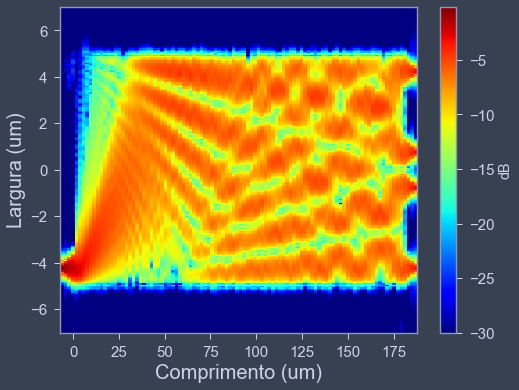

In [158]:
Elog = 10*np.log10(E)
plt.rcParams["figure.figsize"] = (8,6)
plt.pcolormesh(x[:,0]*1e6,y[:,0]*1e6,Elog,cmap = 'jet',vmin=-30)
plt.xlabel('Comprimento (um)',fontsize=20)
plt.ylabel('Largura (um)',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar = plt.colorbar(label='dB')
cbar.ax.tick_params(labelsize=15)
plt.savefig('E Log')

In [143]:
sweepin = mode.getsweepresult('sweep in','S1')
print(sweepin['T'][9])

[0.10241525 0.11624252 0.13020723 0.1440703  0.15749841 0.17027387
 0.18197621 0.19259073 0.20196895 0.21007075 0.21659925 0.22159945
 0.224943   0.22653923 0.22622391 0.22402751 0.21995733 0.21408274
 0.20660584 0.19783105]


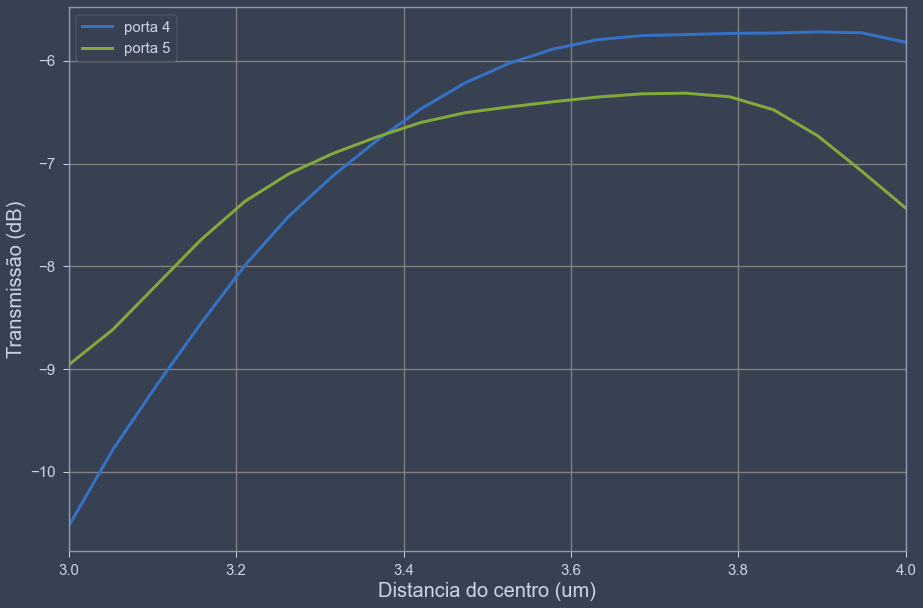

In [151]:
x = np.linspace(3,4,20)
plt.plot(x,10*np.log10(abs(mode.getsweepresult('sweep out','S2')['T'][9])),label='porta 4',linewidth=3)
plt.plot(x,10*np.log10(abs(mode.getsweepresult('sweep out 2','S2')['T'][9])),label='porta 5',linewidth=3)
#plt.plot(x,10*np.log10(abs(mode.getsweepresult('sweep in','S3')['T'][9])),label='porta5',linewidth=3)
#plt.plot(x,10*np.log10(abs(mode.getsweepresult('sweep in','S4')['T'][9])),label='porta6',linewidth=3)
plt.legend(fontsize=15)
#plt.ylim(-7,-5.5)
plt.xlim(3,4)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Distancia do centro (um)',fontsize=20)
plt.ylabel('Transmissão (dB)',fontsize=20)
plt.grid(color='grey')
plt.savefig('sweepcomprimento')

In [13]:
s = mode.getsweepresult('sweepespessura','s')
print(s.keys())
x = s['Espessura']
matrix = s['user s matrix']
matrix = abs(matrix)**2
print(np.shape(matrix))

plt.plot(x,10*np.log10(abs(mode.getsweepresult('sweep out','S2')['T'][9])),label='porta 4',linewidth=3)
plt.plot(x,10*np.log10(abs(mode.getsweepresult('sweep out 2','S2')['T'][9])),label='porta 5',linewidth=3)
plt.plot(x,10*np.log10(abs(mode.getsweepresult('sweep out 2','S2')['T'][9])),label='porta 5',linewidth=3)
plt.legend(fontsize=15)
#plt.ylim(-7,-5.5)
plt.xlim(3,4)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Distancia do centro (um)',fontsize=20)
p

dict_keys(['index_1', 'index_2', 'Espessura', 'user s matrix', 'Lumerical_dataset'])
(6, 6, 3)
